In [65]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from matplotlib.patches import ConnectionPatch
from pathlib import Path
import warnings

from multimodal_emg import emg_wave_model
from multimodal_emg import three_stage_fit
from tests.test_multimodal_emg import EchoMultiModalTester

## Synthetic echo data generation

In [66]:
np.random.seed(3008)

# echo parameter definition
fs = 3e5
time_interval = 5e-3
x = np.arange(0, time_interval, 1 / fs)
gt_data = np.zeros(len(x))
gt_params = []
echo_num = 4
alphas = np.random.standard_normal(size=echo_num) + 5.5
mus = np.random.uniform(low=0.001, high=time_interval * 0.9, size=echo_num)
sigmas = np.random.uniform(low=5e-5, high=1e-4, size=echo_num)
etas = np.random.uniform(low=2, high=6, size=echo_num)
fkhzs = 4e1 + (np.random.uniform(size=echo_num)-.5) * 1e-2
phis = np.random.uniform(low=-np.pi, high=+np.pi, size=echo_num)

# custom parameter change to demonstrate capability
sigmas[1] *= 2
# move components closer together for better visualization
mus[-2] -= x[200]
mus[-1] -= x[550]

# create echoes
for i in range(echo_num):
    gt_data += emg_wave_model(
        alpha=alphas[i],
        mu=mus[i],
        sigma=sigmas[i],
        eta=etas[i],
        fkhz=fkhzs[i],
        phi=phis[i],
        x=x,
    )
    gt_params.append([alphas[i], mus[i], sigmas[i], etas[i], fkhzs[i], phis[i]])

# normalization  and signed 8-bit quantization
gt_data = np.round(gt_data/(max(abs(gt_data)))*117).astype(np.int8)

# add noise to disturb echo detection
data_arr = EchoMultiModalTester.add_noise(gt_data, 10)

# initial estimates from gradient-based detection
echo_list = [
    [325, 364, 8.7927324613085, 117.7634958881404, 0.27466666666666667, 78], 
    [449, 468, 13.014158223359411, 91.82957799556831, 0.27466666666666667, 38], 
    [538, 564, 21.197091240316798, 68.25852001312091, 0.27466666666666667, 38], 
    [632, 656, 7.922441719367008, 108.61894408574061, 0.27466666666666667, 44],
]

# add oscillating estimates (alpha, mu, sigma, skew) for optimization
echo_feats = list(
    chain(
        *[
            # alpha, mu in s, sigma in s, eta
            [echo_list[i][3], echo_list[i][1]/fs, (x[echo_list[i][1]]-x[echo_list[i][0]])/3, 3, 4e1, 0]
            for i in range(len(echo_list))
        ]
    )
)

## Band pass filtering 

In [67]:
def detect_freq(channel_data):

    w = np.fft.fft(channel_data)
    freqs = np.fft.fftfreq(len(w))
    idx = np.argmax(np.abs(w))
    freq = abs(freqs[idx]) * 2

    return freq

def bandpass_filter(channel_data, center_freq):

    if center_freq <= 0:
        warnings.warn('Skip bandpass filter due to invalid frequency')
        return channel_data

    # set cut-off frequencies (where amplitude drops by 3dB)
    sw = 0.5
    lo, hi = np.array([sw, (2-sw)]) * center_freq
    lo, hi = max(0, lo), min(1-np.spacing(1), hi)
    
    from scipy import signal
    sos = signal.butter(5, [lo, hi], btype='band', output='sos')
    y = signal.sosfiltfilt(sos, channel_data)

    return y

# detect relative frequency
center_freq = detect_freq(data_arr)

# filter around center frequency
filt_arr = bandpass_filter(data_arr, center_freq)

## MEMG Regression with oscillation term

In [68]:
# perform multi-stage regression
p_star, wav_result = three_stage_fit(
    filt_arr,
    features=np.array(echo_feats),
    x=x,
)

## Results

In [69]:
data_psnr = 20*np.log((2**8-1) / (np.sum((gt_data - data_arr)**2)/len(gt_data))**.5)
print("Data PSNR amounts to  %s dB" % round(data_psnr, 4))

emg_psnr = 20*np.log((2**8-1) / (np.sum((gt_data - wav_result)**2)/len(gt_data))**.5)
print("EMG PSNR amounts to  %s dB" % round(emg_psnr, 4))

Data PSNR amounts to  65.0596 dB
EMG PSNR amounts to  109.9023 dB


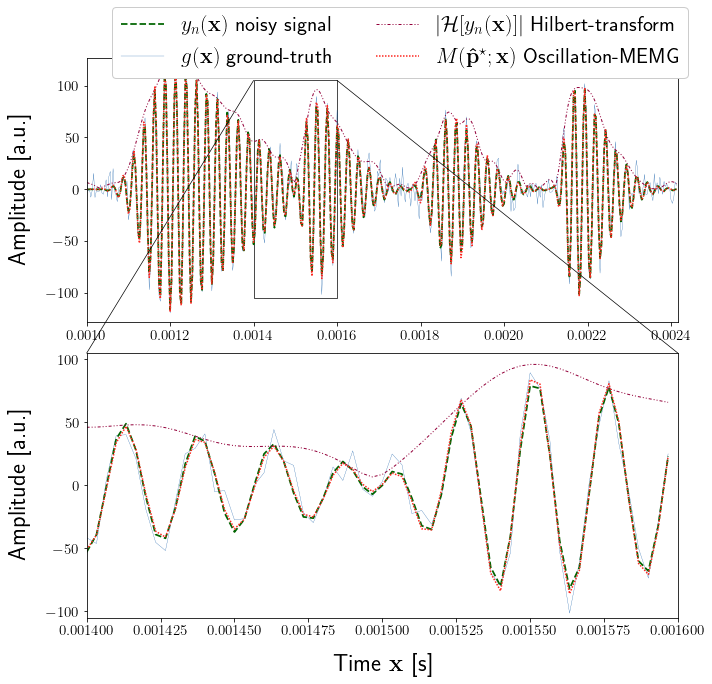

In [70]:
def mulitmodal_ius_plot(x, channel_data, hilbert_data, gt_data=None, fitted_data=None):

    import matplotlib
    matplotlib.rcParams['text.usetex'] = True
    import matplotlib.pyplot as plt
    from matplotlib.patches import ConnectionPatch, Rectangle

    colors = ['#0051a2', 'darkgreen', '#ffd44f', '#fd271f', '#93003a', '#808080', '#601090']#
    lwidths = [.25, 1.75, 1, 1, .75, 1.5]

    # Create main container
    fig = plt.figure(figsize=(10, 10))
    plt.subplots_adjust(bottom = 0., left = 0, top = 1., right = 1)

    # Create upper axes
    xs1, xs2 = 300, -775
    sub1 = fig.add_subplot(2,2,(1,2)) # two rows, two colums, combined third and fourth cell
    (l2,) = sub1.plot(x[xs1:xs2], channel_data[xs1:xs2], linestyle='solid', linewidth=lwidths[0], color=colors[0], label="$y_n(\mathbf{x})$ noisy signal")
    (l1,) = sub1.plot(x[xs1:xs2], gt_data[xs1:xs2], color = colors[1], linestyle='dashed', linewidth=lwidths[1], label="$g(\mathbf{x})$ ground-truth")
    (l3,) = sub1.plot(x[xs1:xs2], hilbert_data[xs1:xs2], linestyle=(0, (3, 2, 1, 2, 1, 2)), linewidth=lwidths[2], color=colors[4], label="$|\mathcal{H}[y_n(\mathbf{x})]|$ Hilbert-transform")
    (l6,) = sub1.plot(x[xs1:xs2], fitted_data[xs1:xs2], color=colors[3], linestyle=(0, (1,1)), linewidth=lwidths[5], label="$M(\mathbf{\hat{p}^\star};\mathbf{x})$ Oscillation-MEMG")
    sub1.set_xlim(x[xs1], x[xs2])
    sub1.set_ylim(-128, 127)
    #sub1.set_xlabel(r'Time $\mathbf{x}$ [s]', fontsize=24, labelpad = 15)
    sub1.set_ylabel(r'Amplitude [a.u.]', fontsize=24, labelpad = 15)
    sub1.tick_params(axis='both', which='major', labelsize=15)
    sub1.tick_params(axis='both', which='minor', labelsize=13)

    # Create upper axes
    sub2 = fig.add_subplot(2,2,(3,4))
    xs3, xs4 = 420, 480
    rect_center_x = (x[xs3]+x[xs4])/2
    rect_height = 210
    sub2.plot(x[xs3:xs4], channel_data[xs3:xs4], linestyle='solid', linewidth=lwidths[0], color=colors[0], label="$y_n(\mathbf{x})$ noisy signal")
    sub2.plot(x[xs3:xs4], gt_data[xs3:xs4], color=colors[1], linestyle='dashed', linewidth=lwidths[1], label="$g(\mathbf{x})$ ground-truth")
    sub2.plot(x[xs3:xs4], hilbert_data[xs3:xs4], linestyle=(0, (3, 2, 1, 2, 1, 2)), linewidth=lwidths[2], color=colors[4], label="$|\mathcal{H}[y_n(\mathbf{x})]|$ Hilbert-transform")
    sub2.plot(x[xs3:xs4], fitted_data[xs3:xs4], color=colors[3], linestyle=(0, (1,1)), linewidth=lwidths[5], label="$M(\mathbf{\hat{p}^\star};\mathbf{x})$ Oscillation-MEMG")
    sub2.set_xlim(x[xs3], x[xs4])
    sub2.set_ylim(-rect_height/2, rect_height/2)
    sub2.set_ylabel(r'Amplitude [a.u.]', fontsize=24, labelpad = 15)
    sub2.tick_params(axis='both', which='major', labelsize=15)
    sub2.tick_params(axis='both', which='minor', labelsize=13)
    sub2.set_xlabel(r'Time $\mathbf{x}$ [s]', fontsize=24, labelpad = 15)

    # Create left side of Connection patch for first axes
    con1 = ConnectionPatch(xyA=(x[xs3], sub2.get_ylim()[1]), coordsA=sub2.transData, 
                        xyB=(x[xs3], rect_height/2), coordsB=sub1.transData, color = 'k', linewidth=.7)
    # Add left side to the figure
    fig.add_artist(con1)

    # Create right side of Connection patch for first axes
    con2 = ConnectionPatch(xyA=(x[xs4], sub2.get_ylim()[1]), coordsA=sub2.transData, 
                        xyB=(x[xs4], rect_height/2), coordsB=sub1.transData, color = 'k', linewidth=.7)
    # Add right side to the figure
    fig.add_artist(con2)

    rect = Rectangle((rect_center_x-(x[xs4]-x[xs3])/2, -rect_height/2), width=(x[xs4]-x[xs3]), height=rect_height, fill=False, color='k', linewidth=.7)
    sub1.add_artist(rect)

    handles, labels = sub1.get_legend_handles_labels()
    fig.legend(handles=[l1, l2, l3, l6], labels=labels, fontsize=21.5, fancybox=True, framealpha=1, ncol=2, bbox_to_anchor=(0.475, 0.46, 0.5, 0.5))

    # Save figure with nice margin
    plt.tight_layout(rect=(0,0,1,.89))
    plt.savefig(Path.cwd() / 'docs' / 'figs' / 'denoising_emg.svg', transparent=True, dpi=300, pad_inches=.0)
    plt.savefig(Path.cwd() / 'docs' / 'figs' / 'denoising_emg.eps', transparent=True, dpi=300, pad_inches=.0)
    plt.show()

mulitmodal_ius_plot(x, data_arr, EchoMultiModalTester.hilbert_transform(filt_arr), gt_data=gt_data, fitted_data=wav_result)